## Dataset Description
<p>
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.
</p>

File and Data Field Descriptions

train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
* PassengerId - Id for each passenger in the test set.
* Transported - The target. For each passenger, predict either True or False.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Import dataframe and visualize content
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
pred = pd.DataFrame(test['PassengerId'])
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Define Pipeline

In [3]:
def has_siblings(x,y):
    if x in y:
        return 1
    else:
        return 0

In [4]:
def pipeline(df):
    # Create the 'Services' column as the sum of the individual columns
    for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']:
        df[col].fillna(0, inplace=True)
    
    df['CryoSleep'].fillna(-1, inplace=True)
    df['VIP'].fillna(-1, inplace=True)
    #df['Services'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']

    # Drop the individual columns
    #df.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], inplace=True)
    
    # Replace NaN values in the 'Age' column with mean age op people having no services
    non_null_age = df[~df['Age'].isna()]
    #mean_age = non_null_age[non_null_age['Services'] == 0.].Age.mean()
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    # Check if 'Age' is not equal to 0, then apply log transformation, otherwise keep it as it is
    df['Age'] = df['Age'].apply(lambda x: np.log2(x) if x != 0 else x)
    
    df['Passenger1'] = df.PassengerId.apply(lambda x:x.split('_')[0])
    #df['HasSiblings'] = df['Passenger1'].apply(lambda x:has_siblings(x,df['Passenger1'][df['Passenger1'].duplicated()].values))
    df.drop(columns=['PassengerId', 'Passenger1', 'Name'], inplace=True)
    
    # Create dummy variables for 'HomePlanet'
    homeplanet_dummies = pd.get_dummies(df['HomePlanet'])

    # Concatenate the dummy variables with the original DataFrame
    df = pd.concat([df, homeplanet_dummies], axis=1)

    # Drop the original 'HomePlanet' column as it is no longer needed
    df.drop(columns=['HomePlanet'], inplace=True)
    
    # Create dummy variables for 'Destination'
    Destination_dummies = pd.get_dummies(df['Destination'])

    # Concatenate the dummy variables with the original DataFrame
    df = pd.concat([df, Destination_dummies], axis=1)

    # Drop the original 'Destination' column as it is no longer needed
    df.drop(columns=['Destination'], inplace=True)
    
    # Define a mapping for replacement
    mapping = {True: int(1), False: int(0), pd.NA: -1}

    # Replace values in the specified columns using the mapping
    df['CryoSleep'] = df['CryoSleep'].replace(mapping)
    df['VIP'] = df['VIP'].replace(mapping)
    try:
        df['Transported'] = df['Transported'].replace(mapping)
    except:
        pass
    
    # Split the 'Cabin' column by '/'
    cabin_parts = df['Cabin'].str.split('/')

    # Extract 'string1' and 'string2' from the list of splits
    df['CabinLetter'] = cabin_parts.str[0] + cabin_parts.str[-1]
    
    # Use factorize to convert each unique value to a number
    #df['CabinLetter'] = pd.factorize(df['CabinLetter'])[0]

    # Replace NaN values with -1
    #df['CabinLetter'].fillna(-1, inplace=True)
    
    df['CabinNumber'] = cabin_parts.str[1]
    df['CabinNumber'].fillna(-1, inplace=True)
    
    df.drop(columns=['Cabin'], inplace=True)
    
    
    # Create dummy variables for 'HomePlanet'
    CabinLetter_dummies = pd.get_dummies(df['CabinLetter'])

    # Concatenate the dummy variables with the original DataFrame
    df = pd.concat([df, CabinLetter_dummies], axis=1)

    # Drop the original 'HomePlanet' column as it is no longer needed
    df.drop(columns=['CabinLetter'], inplace=True)
    
    
    return df

In [5]:
df = pipeline(df)
df.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'Earth', 'Europa', 'Mars',
       '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', 'CabinNumber', 'AP',
       'AS', 'BP', 'BS', 'CP', 'CS', 'DP', 'DS', 'EP', 'ES', 'FP', 'FS', 'GP',
       'GS', 'TP', 'TS'],
      dtype='object')

## Apply Machine Learning

(array([863.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 876.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

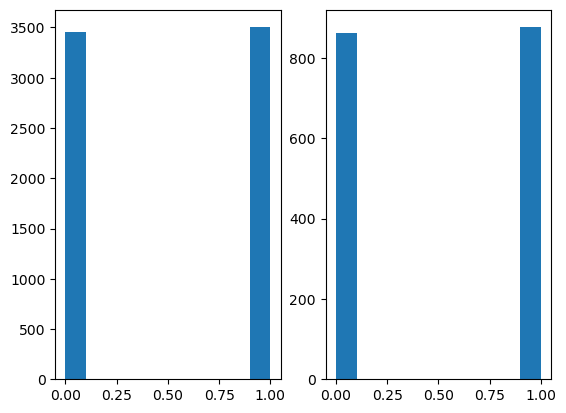

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 1234)
for train_indices,test_indices in split.split(df,df[['Transported']]):
    train_set = df.iloc[train_indices]
    test_set = df.iloc[test_indices]
plt.subplot(1,2,1)
plt.hist(train_set.Transported)
plt.subplot(1,2,2)
plt.hist(test_set.Transported)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(train_set.drop(['Transported'],axis = 1))
y_train = train_set.Transported.to_numpy()
scaler = StandardScaler()
X_test = scaler.fit_transform(test_set.drop(['Transported'],axis = 1))
y_test = test_set.Transported.to_numpy()


In [8]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
prediction = rf.predict(X_test)
err = (rf.predict(X_test)-y_test)**2
1 - err.sum()/len(err)

0.7912593444508338

In [ ]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn import svm
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Best Parameters for each classifier
Best_Parameters_CSV = {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best_Parameters_CatBoostClassifier =  {'depth': 10, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
Best_Parameters_RandomForest  = {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}
Best_Parameters_ExtraTrees = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Best_Parameters_Ridge = {'alpha': 0.1, 'solver': 'auto'}
Best_Parameters_KNN = {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}

voter = [('ada' , ensemble.AdaBoostClassifier(n_estimators=300, learning_rate=0.1, random_state=0)),
         ('bag' , ensemble.BaggingClassifier(max_samples=0.25, n_estimators=300,random_state=0)),
         ('nvc' , svm.NuSVC(probability=True)),
         ('cat', CatBoostClassifier(**Best_Parameters_CatBoostClassifier, verbose=False)),
         ('lda' , LinearDiscriminantAnalysis()),
         ('ttc' , ExtraTreesClassifier(**Best_Parameters_ExtraTrees)),
         ('lvc' , SVC(**Best_Parameters_CSV)),
         ('rcc',RidgeClassifier(**Best_Parameters_Ridge)),
         ('rfc',RandomForestClassifier(**Best_Parameters_RandomForest)),
         ('knc',KNeighborsClassifier(**Best_Parameters_KNN))]

vote_m = ensemble.VotingClassifier(estimators = voter , voting = 'hard')

vote_m.fit(X_train,y_train)
predictions = vote_m.predict(X_test)

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))



In [ ]:
test = pipeline(test)

scaler = StandardScaler()
test_scaled = scaler.fit_transform(test)
predictions_pipeline = vote_m.predict(test_scaled)

pred['Transported'] = predictions_pipeline
pred['Transported'] = pred['Transported'].apply(lambda x:'True' if x == 1 else 'False')
print(pred)
pred.to_csv('predictions.csv',index = False)